In [ ]:
#借助 Intel(R) Extension for Scikit-learn，您可以加速您的 Scikit-learn 应用程序，并且仍然完全符合所有 Scikit-Learn API 和算法。这是一款免费软件 AI 加速器，可为各种应用带来超过10-100 倍的加速。而且您甚至不需要更改现有代码！
# !python -m pip install pandas matplotlib scikit-learn-intelex scikit-learn openpyxl tensorboard seaborn ipykernel ipywidgets keras plotly plotly_express
# !python -m pip install  tensorflow==2.15.*
# !python -m pip install  tensorflow[and-cuda]==2.15.*
#


In [ ]:
# 本导入顺序可以看到类型
import tensorflow as tf
import keras
# import tensorflow_datasets as tfds
import datetime
import os
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
from sklearn import preprocessing as skl
from sklearn.model_selection import train_test_split

# from tensorflow import keras

from keras import layers
from keras import models



patch_sklearn()
# from attention_utils import get_activations

#更好地兼容 Python 3 的行为和特性，使得代码可以在 Python 2 和 Python 3 下运行得更加一致
# from __future__ import absolute_import,division,print_function,unicode_literals
from matplotlib import pyplot as plt
from matplotlib import ticker as mt
# 或者直接指定字体文件路径
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans Mono']  # 系统自带的黑体
plt.rcParams['font.serif'] = ['SimHei']  # 系统自带的宋体
plt.rcParams['font.family'] = [
    'SimHei',
    'DejaVu Sans Mono',  # 显示负号的字体
    # 'Liberation Mono',
    'Consolas',
    'Courier New',
    'monospace',
    'sans-serif',
    'serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
]
plt.rcParams['axes.unicode_minus'] = False  # 设置matplotlib显示正常的负号而非减号样式

In [ ]:
print(' ')
print(f'{datetime.datetime.now()} tensorflow版本:', tf.__version__)
gpus = tf.config.experimental.list_physical_devices("GPU")
print(' ')
print('gpus： ')
print(gpus)
print(' ')
print('gpus')
# 查看系统中可见的GPU设备
print("Available GPU devices:", tf.config.list_physical_devices("GPU"))


In [ ]:
# # 读取数据

from load_data import load_fixed_data, categories

R_CREATE = False
R_CREATE = True


def create_dynamic_globals(dyn_name, value, global_vars, read_cache: bool = True):
    """
    :param dyn_name: 动态变量名
    :param value: 动态变量值
    :param global_vars: 全局变量字典
    :return:
    """
    # print(dyn_name, global_vars[dyn_name])
    if read_cache and (R_CREATE or dyn_name not in global_vars or global_vars[dyn_name] == None):
        # 如果确实需要在全局作用域创建真正的全局变量，可以使用exec，但这不是推荐做法
        if callable(value):

            v = value(dyn_name)
            s = f'global {dyn_name}; {dyn_name} = v'
            # print(s)
            exec(s)
        else:
            exec(f'global {dyn_name}; {dyn_name} = {value}')

    return globals()[dyn_name]


def create_global_vars(global_vars, varprefix: str = 'data_', read_cache: bool = True):

    for gvar in global_vars:
        #
        if gvar.startswith('_'):
            continue
        if gvar.startswith(varprefix):
            print(gvar, )
            create_dynamic_globals(gvar, lambda f: load_fixed_data(f'./data/{f}.xlsx'), global_vars)


data_17 = pd.DataFrame()
data_21 = data_17
data_22 = data_17
data_23 = data_17
data_24 = data_17

create_global_vars(globals(), varprefix='data_')

# data_17.dtypes

In [ ]:
from libs.config import *

In [ ]:
#组合数据集
from load_data import categories

numeric_col_names = [
    '原始重量',
    '稳定重量',
    '轴重',
    'su_ad',
    'wpu_x',
    'wpu_y',
    'wpu_z',
    'su_x',
    'su_y',
    'su_z',
    '原始重量_diff',
    '稳定重量_diff',
    '轴重_diff',
    'su_ad_diff',
    'wpu_x_diff',
    'wpu_y_diff',
    'wpu_z_diff',
    'su_x_diff',
    'su_y_diff',
    'su_z_diff',
]

# delete some
# ['Unnamed: 0' ,
# 'label'      , '时间'         , '轨迹时间'       , '速度',, '估计重量'
# '原始重量'       , '稳定重量'       , '轴重'         , 'su_ad',
# '原始重量_diff'  , '稳定重量_diff'  , '轴重_diff'    , 'su_ad_diff',
# 'wpu_x'      , 'wpu_y'      , 'wpu_z'      ,
# 'wpu_x_diff' , 'wpu_y_diff' , 'wpu_z_diff',
# 'su_x'       , 'su_y'       , 'su_z'       ,
# 'su_x_diff'  , 'su_y_diff'  , 'su_z_diff'
# ]
label_col_names = ["label"]
time_col_names = ["时间", "轨迹时间"]

all_col_names = numeric_col_names + label_col_names + time_col_names
df17, df21, df22, df23, df24 = data_17[all_col_names], data_21[all_col_names], data_22[all_col_names], data_23[all_col_names], data_24[all_col_names]
origindata = pd.concat([df17, df21, df22, df23, df24], axis=0, ignore_index=True)

# print(origindata.columns)

print(origindata.shape, origindata.columns, origindata.dtypes)

In [ ]:
# check 数据集有缺失值
shapea= origindata.shape
df = origindata.dropna()
shapeb =df.shape
print(shapea, shapeb)
if shapea != shapeb:
    print(shapea,shapeb)
    ValueError("数据集有缺失值")

# missing_values

In [ ]:

def windowed_dataset(dataset: tf.data.Dataset, window_size=5, shift=1, stride=1):
    windows = dataset.window(window_size, shift=shift, stride=stride, drop_remainder=True)

    def sub_to_batch(t1, t2=None):
        t1_batches = t1.batch(window_size, drop_remainder=True)

        if t2 is not None:
            t2_batches = t2.batch(window_size, drop_remainder=True)
            return tf.data.Dataset.zip(t1_batches, t2_batches)
        else:
            return t1_batches

    windows = windows.flat_map(sub_to_batch)
    return windows


from turtle import up
import scipy
from scipy.stats import iqr

p = 1.5


def replace_iqr_outliers(df: pd.DataFrame, colums: list[str]):
    q = 0.25
    _df = df.copy()
    for column in colums:
        _df[column] = _df[column].astype(float)
        q1 = _df[column].quantile(q)  #.quantile(0.25)
        q3 = _df[column].quantile(1 - q)  #.quantile(0.75)
        iqr_value = iqr(_df[column], rng=(q * 100, (1 - q) * 100))
        print('------', iqr_value)

        lower_bound = q1 - p * iqr_value
        upper_bound = q3 + p * iqr_value
        _df.loc[_df[column] < lower_bound, column] = lower_bound
        _df.loc[_df[column] > upper_bound, column] = upper_bound

    return _df

In [67]:
# 准备数据
# 使用Savitzky-Golay 滤波器后得到平滑图线
from numpy import ndarray
from scipy import signal as sg
from libs.expandrows import dataframe_filter
from joblib import dump, load

numeric_abs_col_names = [str(col + '_abs') for col in numeric_col_names]
numeric_smooth_col_names = [str(col + '_smooth') for col in numeric_col_names]
feature_col_names = numeric_col_names + numeric_abs_col_names + numeric_smooth_col_names  # 暂时去掉 时间
feature_col_num = len(feature_col_names)

class_num = len(categories)


def proccess_data_df(df: pd.DataFrame):

    df = df.copy()

    # 假设df是一个时间序列DataFrame，其中索引是时间戳
    # if not '时间' in df.index.names or not isinstance(df.index, pd.DatetimeIndex):
    #     df.sort_values('时间', axis=0, ascending=True)
    #     df.set_index('时间', inplace=True)  # 如果还没有将时间戳设为索引
    #     df = df.sort_index(axis=0, ascending=True)
    # df.interpolate(method='linear', inplace=True)
    # 确保索引已经是datetime类型
    # df.index = pd.to_datetime(df.index)

    # # 计算相邻时间点之间的差值
    # time_diffs = df.index.to_series(name='timespan').diff()
    # print(time_diffs)
    # # 找出那些间隔超过3秒的索引
    # large_gaps = time_diffs[time_diffs > pd.Timedelta(seconds=6)].index
    # print(large_gaps)
    # # 若要查看每段连续的间隔超过3秒的区间
    # gaps_df = pd.DataFrame({'start': large_gaps[:-1], 'end': large_gaps[1:]})
    # # 若只需要每个间隔的开始时间
    # gap_starts = large_gaps[:-1]

    # print("间隔超过3秒的开始时间点：", gap_starts)

    df = replace_iqr_outliers(df, numeric_col_names)

    for a, b, c in zip(numeric_col_names, numeric_abs_col_names, numeric_smooth_col_names):
        df[b] = abs(df[a])
        df[c] = np.convolve(df[b].astype(float), np.ones((5, )), mode='same')

    # df_filter_important = dataframe_filter(df_iqr, 30)  # 过滤为0的数据

    # df_filter_important

    # df_expanded = df_expanded  #.dropna()

    # df_selected.insert(0,co)
    # df_selected[col] = sg.savgol_filter(df_selected[col].astype(float), window_length=21, delta=0.5, polyorder=1, mode='constant')
    # df_selected[col] = np.convolve(df_selected[col].astype(float), np.ones((5, )), mode='same')
    # df_selected[col] = abs(df_selected[col].astype(float))
    # df_selected[col] = np.convolve(df_selected[col].astype(float), np.ones((5, )), mode='same')

    df_smooth = df[feature_col_names + label_col_names + time_col_names]
    # 假设你有多个列需要比较
    columns_to_plot = feature_col_names + label_col_names
    # df_smooth.reset_index()
    df_to_plot = df_smooth[columns_to_plot]

    # dfview.reset_index(drop=True, inplace=True)
    # df_to_plot

    if os.path.exists('scaler.joblib'):
        scaler = load('scaler.joblib')
        normalized = scaler.fit_transform(df_to_plot[feature_col_names])
        print('exsited scaler.joblib')
    else:
        scaler = skl.StandardScaler()
        normalized = scaler.fit_transform(df_to_plot[feature_col_names])
        dump(scaler, 'scaler.joblib')
        print('New scaler.joblib')

    data = pd.DataFrame(normalized, columns=feature_col_names)
    data[label_col_names] = df_smooth[label_col_names]
    return data


def proccess_data(df_input: pd.DataFrame):
    df_to_plot = proccess_data_df(df_input)
    x = tf.data.Dataset.from_tensor_slices(df_to_plot[feature_col_names])

    def one_hot_encoding(label):
        return tf.squeeze(tf.one_hot(label, depth=class_num))

    y = tf.data.Dataset.from_tensor_slices(df_to_plot[label_col_names].astype(int)).map(one_hot_encoding)

    featureTarget = x
    # featureTarget = windowed_dataset(x, time_steps)

    target = windowed_dataset(tf.data.Dataset.zip(featureTarget, y), time_steps).batch(batch_size)

    # total_examples = len(normalized)  # 获取数据集总样本数
    # train_ratio = 0.7  # 训练集占比
    # num_train_examples = int(total_examples * train_ratio)
    # num_val_examples = total_examples - num_train_examples
    # print('total_examples = ', total_examples)
    # print('num_train_examples =', num_train_examples)
    # print('num_val_examples =', num_val_examples)
    # train_dataset = target.take(num_train_examples)
    # val_dataset = target.skip(num_train_examples)

    # trainWindow = train_dataset.prefetch(tf.data.AUTOTUNE)  #.batch(batch_size=batch_size, drop_remainder=True)
    # valWindow = val_dataset.prefetch(tf.data.AUTOTUNE)  #.batch(batch_size=batch_size, drop_remainder=True)

    # # for a, b in trainWindow.take(1):
    # #     print('x=======================')
    # #     print(a.numpy())
    # #     print('y---------------------')
    # #     print(b.numpy())
    # for a, b in valWindow.take(1):
    #     print('a =======================')
    #     print(a.shape)
    #     print(a.numpy())
    #     print('b---------------------')
    #     print(b.shape)
    #     print(b.numpy())
    # # yview=np.array(list(y))
    # # yview = list(y)
    # # normalized
    # # print(yview)
    return target


In [ ]:
# !python -m pip install plotly plotly_express chart-studio cufflinks pyarrow
import plotly_express as px  # import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py
from plotly.subplots import make_subplots
# Cufflinks wrapper on plotly
import cufflinks as cf


# print(df['时间'].shape, df[feature_col_names].shape)
# fig = px.line(df, x='时间', y=feature_col_names + label_col_names,range_x=['2023-12-24 00:00:00', '2023-12-24 09:00:00'])
# fig.show()

In [ ]:
from libs.class_weight import generate_class_weights



# test_weight = generate_class_weights(list(y), multi_class=True, one_hot_encoded=True)

test_weight = {0: 0.3434428692922046, 1: 32.374924653405664, 2: 17.415693904020753}


# y1 = df_filter_important[label_col_names].iloc[:, 0].tolist()
# test_weight1 = generate_class_weights(y1, multi_class=True, one_hot_encoded=False)
# print(test_weight1)
# y1

print('test_weight=======================')
print(test_weight)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir "./logs"
# cmd 当前环境，当前目录 运行   tensorboard --logdir=logs --host=127.0.0.1
# 网页中可以查看模型训练过程trainWindow, valWindow = proccess_data(df)


In [69]:
df = proccess_data_df(pd.concat([df21, df22, df23], axis=0, ignore_index=True))
import matplotlib.pyplot as plt



------ 8451.0
------ 0.0
------ 8440.0
------ 758.0
------ 1831.0
------ 902.0
------ 1866.0
------ 1154.0
------ 246.0
------ 1209.0
------ 311.0
------ 0.0
------ 311.0
------ 28.0
------ 24.0
------ 26.0
------ 24.0
------ 0.0
------ 10.0
------ 5.0
exsited scaler.joblib


c:\AppData\.devhome\conda\envs\py311tf216\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



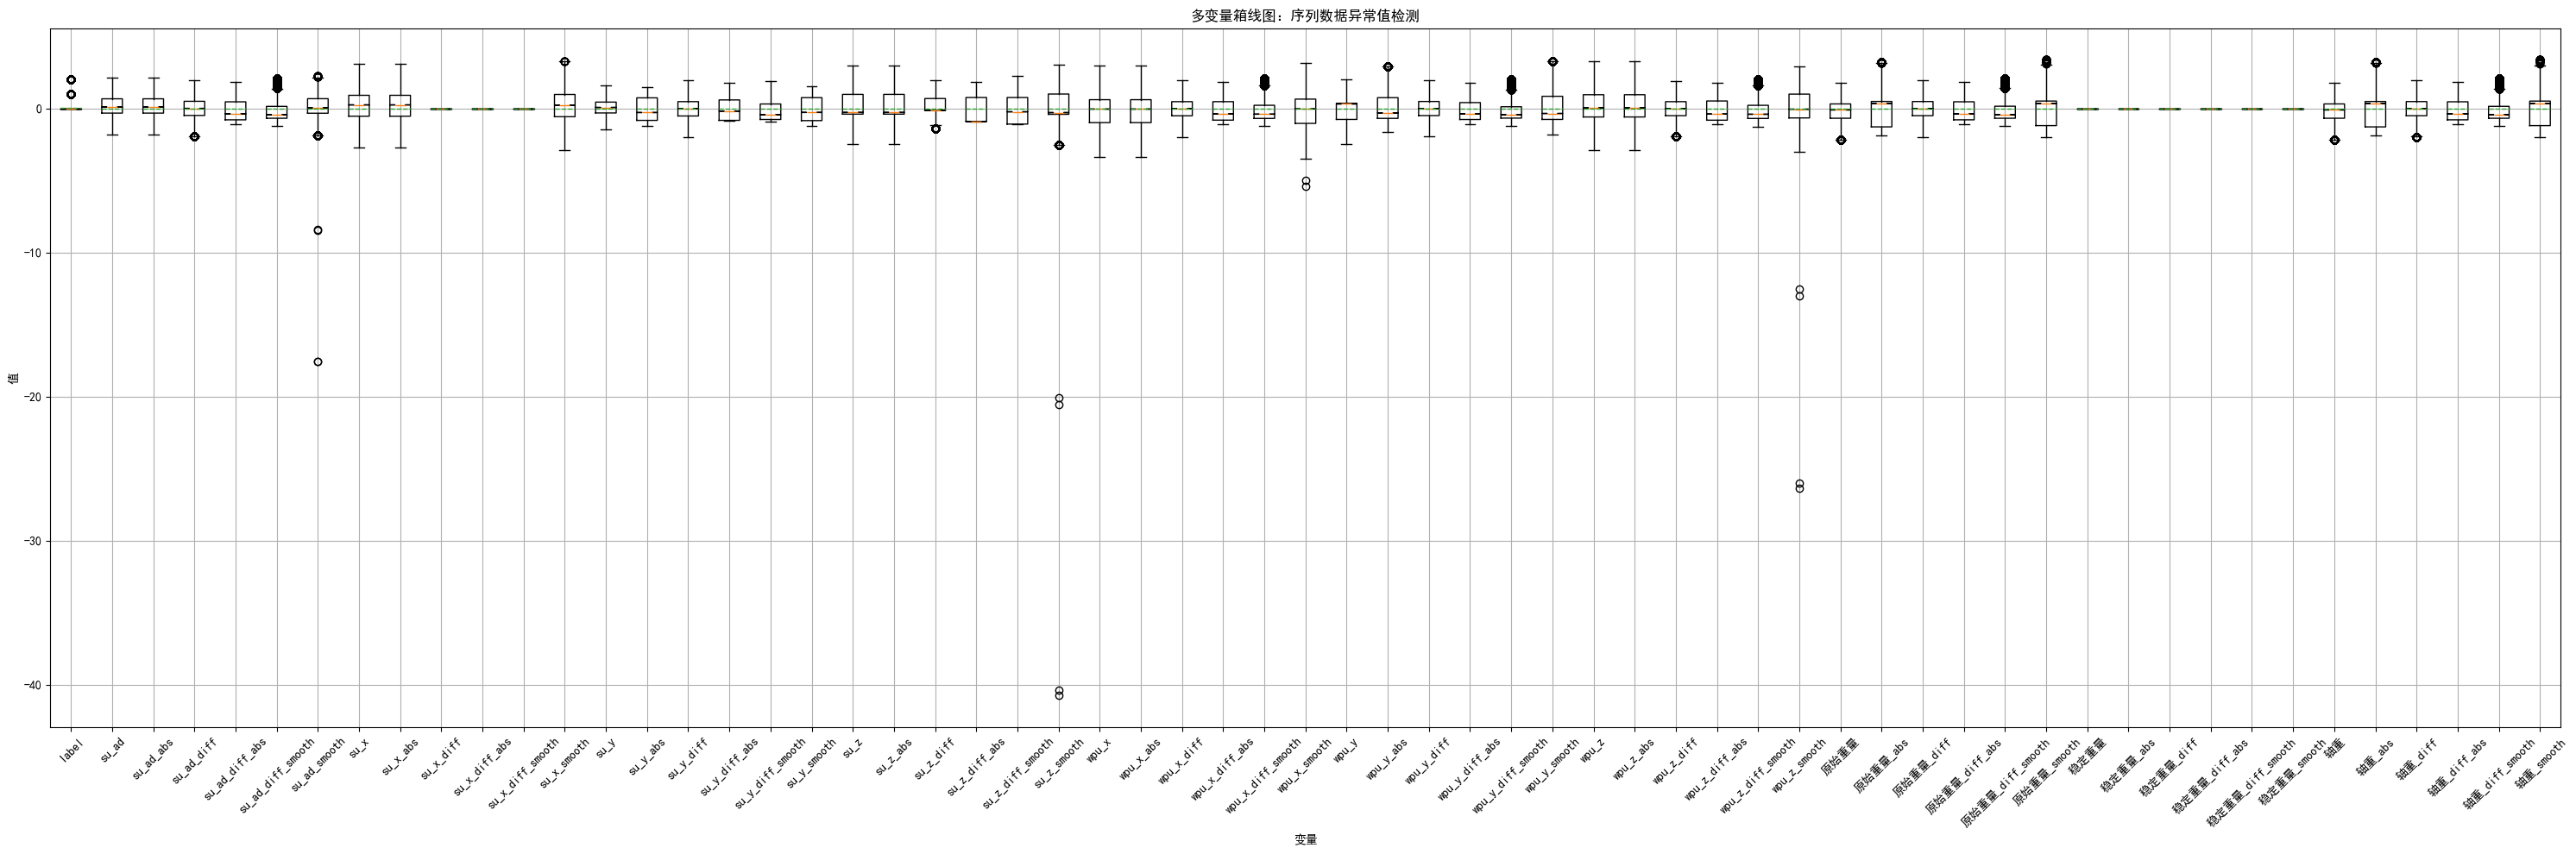

In [65]:
import matplotlib.pyplot as plt

columns_to_plot = feature_col_names + label_col_names
# columns_to_plot = numeric_abs_col_names + numeric_smooth_col_names + label_col_names
# columns_to_plot = numeric_col_names + numeric_abs_col_names + label_col_names
columns_to_plot.sort()
# 绘制多变量箱线图
plt.figure(figsize=(30, 10))
plt.boxplot([df[col] for col in columns_to_plot], labels=columns_to_plot, notch=True, showmeans=True, meanline=True, showfliers=True, whis=p)
plt.title('多变量箱线图：序列数据异常值检测')
plt.xlabel('变量')
plt.ylabel('值')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()

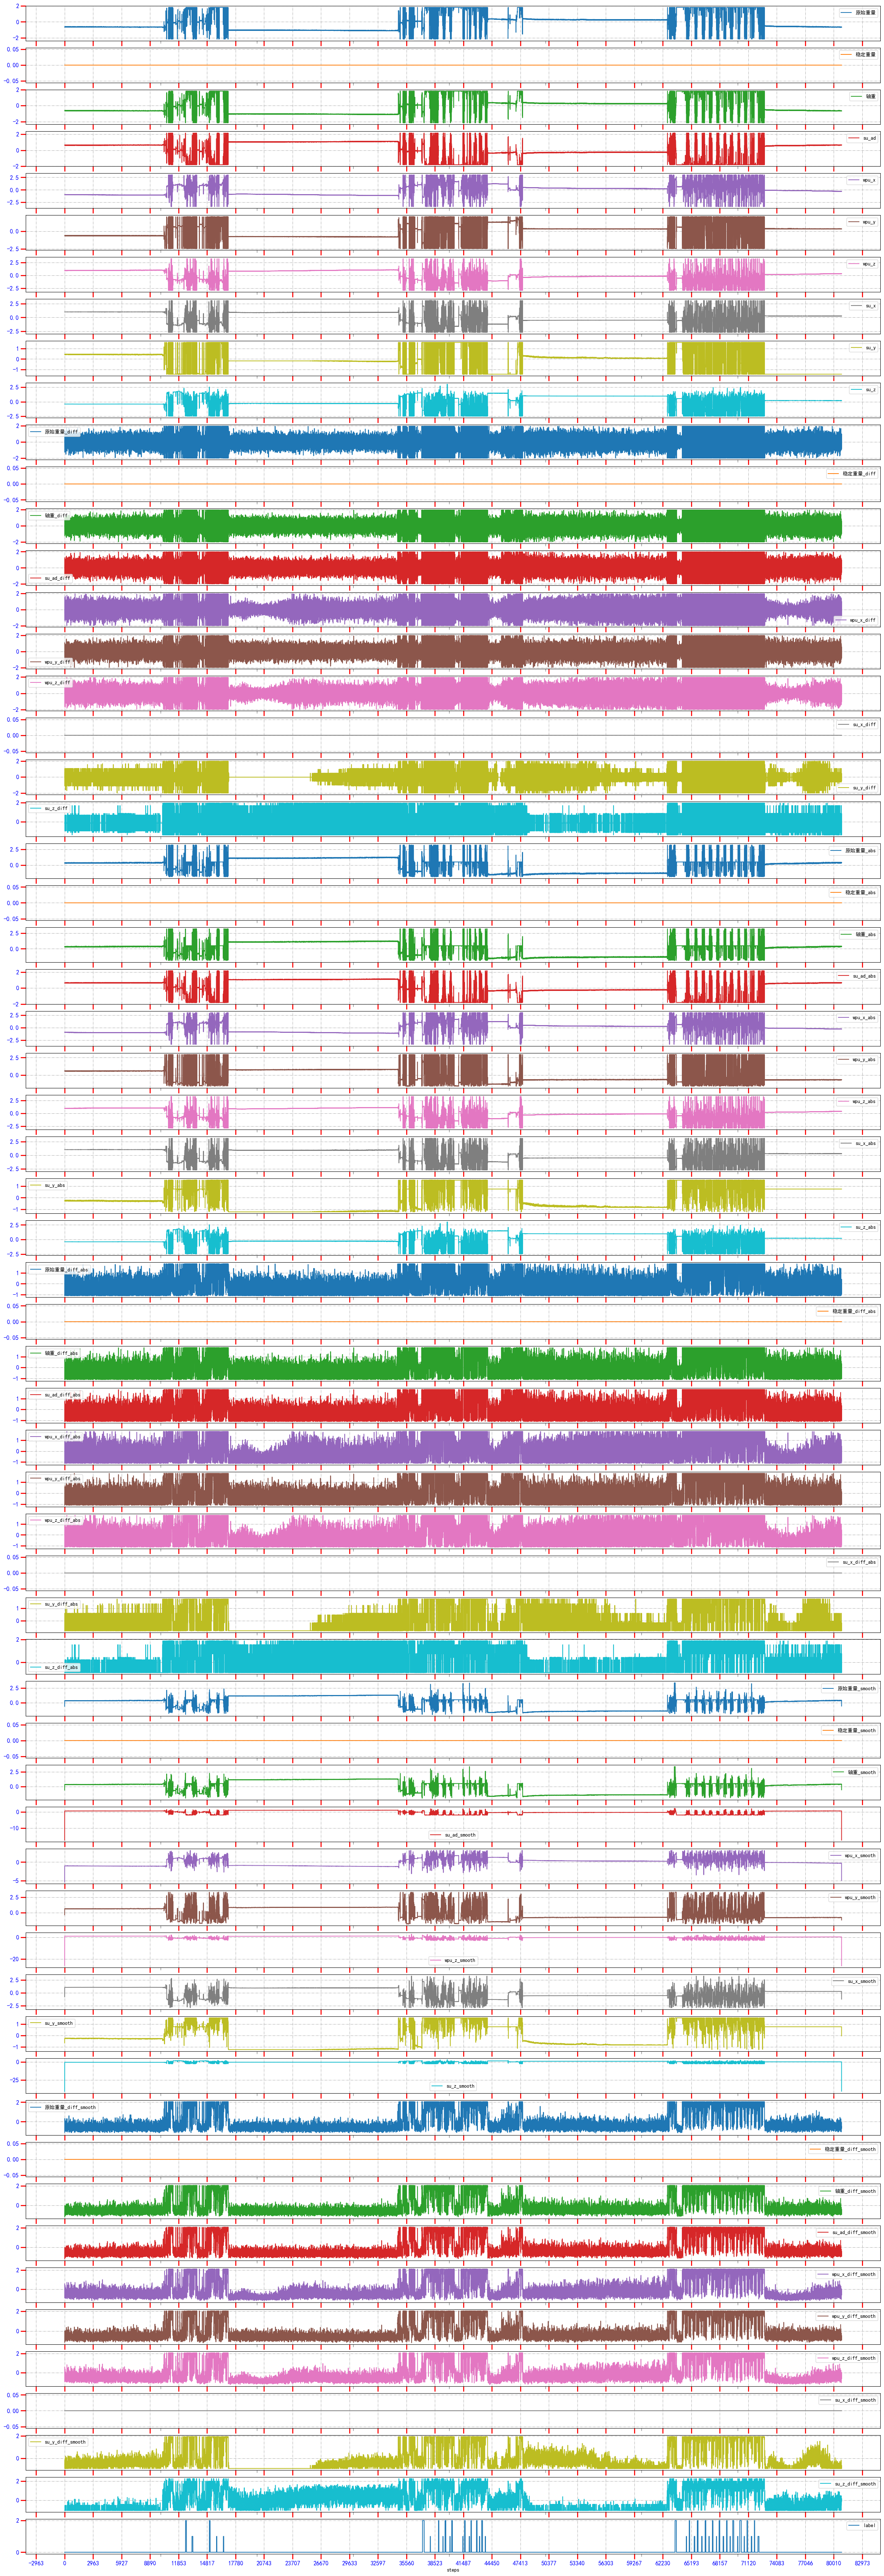

In [59]:
axes: list[plt.Axes] = df.plot(legend=True, subplots=True, figsize=(30, 90), xlabel="steps")
for ax in axes:
    # 设置主刻度线和标签的属性
    ax.tick_params(which='major', length=10, width=2, colors='red', labelsize=12, labelcolor='blue')
    # 设置副刻度线和标签的属性
    ax.tick_params(which='minor', length=5, width=1, colors='gray', labelsize=10, labelcolor='gray')
    ax.grid(True, linestyle='-.', color='0.7')  # 自定义网格线样式
    # ax.set_xlim(left=80000, right=89100)
    min, max = ax.get_xlim()
    ax.xaxis.set_major_locator(mt.MultipleLocator((max - min) / 30))
    # ax.xaxis.set_minor_locator(mt.AsinhLocator(base=round((max - min) // 30), linear_width=1))
plt.show()

In [ ]:
#pd.concat([df17, df21, df22, df23, df24], axis=0, ignore_index=True)
trainWindow = proccess_data(pd.concat([df21, df22, df23], axis=0, ignore_index=True))
valWindow = proccess_data(df24)

In [ ]:
# 编译模型
# %reload_ext autoreload
# %autoreload 2
import keras.src
from libs.callbacks import get_callbacks
from libs.model1 import compile_model

print(feature_col_num)
model: keras.Model = compile_model(time_steps, feature_col_num, class_num, class_num)
initial_learning_rate = 0.01
callbacks = get_callbacks(initial_learning_rate)

In [ ]:
# tf.config.run_functions_eagerly(True)
history = model.fit(
    trainWindow,
    epochs=epochs,
    verbose='auto',
    batch_size=batch_size,
    validation_data=valWindow,
    # validation_split=0.2,
    # shuffle=False,
    callbacks=callbacks,
    class_weight=test_weight,
    workers=10
)

In [ ]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()
    plt.savefig(os.path.join(log_dir, 'learning_rate.png'))

plot_history_metrics(history)



In [ ]:
# 保存模型结构及配置参数
model_json = model.to_json()
with open(os.path.join(log_dir,'model_json.json'),'w') as json_file:
    json_file.write(model_json)


In [ ]:

# print(len(valWindow.repeat(1)))
for x,y in valWindow.repeat(1).take(1):
    print(x,y)

In [ ]:
#对模型在测试集上进行评估
valWindow=valWindow.prefetch(tf.data.AUTOTUNE)
metrics = model.evaluate(valWindow.repeat(1))
for name, value in zip(model.metrics_names, metrics):
    print(name, ': ', value)
# print("accuracy:", metrics[0], "accuracy:", metrics[1])


In [ ]:
predictions=model.predict(valWindow,verbose=1)
# predictions?

In [ ]:
# 如果是多分类问题并且想比较类别概率分布
# 假设y_true和y_pred都是one-hot编码形式
# 可以选择几个样本画柱状图对比


y_true = valWindow.map(lambda x, y: v)
for i, v in enumerate(y_true):
    if i > 3:
        break
    
    print(v)
# print(predictions)
y_pred = tf.argmax(predictions)
# for i in y_pred:
#     # print(i)
#     # print(i)
#     e=1
# num_samples_to_plot = len(y_pred)
# nrows = 2
# plt.figure(figsize=(30, 6))
# plt.subplot(nrows, 1, 1)
# plt.plot(y_true, label='Actual values', linewidth=1.0)
# plt.subplot(nrows, 1, 2)
# plt.plot(y_pred, label='Predicted values', linewidth=1.0)
# plt.legend(fontsize=14)
# plt.xlabel('Sample Index')
# ax = plt.gca()
# ax.set_xlim(left=0, right=num_samples_to_plot)
# plt.ylabel('Value')
# plt.title('Actual vs Predicted Values Comparison')
# plt.grid(True)
# plt.show()
y_pred

In [ ]:
# # data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
# # ax = plt.gca()
# # ax.set_xlim(left=0, right=19000)


# # plt.show()
# times = df22[time_col_names].index.to_numpy()
# display(times)
# plt.plot(times, y, label="Actual", marker="o")
# plt.plot(times, predictions, label="Predicted", linestyle="--", marker="x")

# ax = plt.gca()
# ax.set_xlim(left=12000, right=18000)
# # 添加标题和标签
# plt.title("Actual vs. Predicted Values")
# plt.xlabel("Sample Index")
# plt.ylabel("Value")

# # 添加图例
# plt.legend()

# # 显示图形
# plt.show()

In [ ]:
# display(history.history)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "epoch", "accuracy"], loc="upper right")
plt.show()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.show()

In [ ]:
display(df22.columns)

In [ ]:
# data22, scaler22 = normalize(df22, numeric_col_names)
# X22 = data22[feature_col_names]
# y_test22 =normalizeY( df22[label_col_names])
# x_train22  = np.asarray(X22) .reshape(-1, feature_col_num)
# predY22 = model.predict(x_train22, batch_size=batch_size)


# data23, scaler23 = normalize(df23, numeric_col_names)
# X23 = data23[feature_col_names]
# y_test23 =normalizeY( df23[label_col_names])
# x_train23  = np.asarray(X23) .reshape(-1, feature_col_num)
# predY23 = model.predict(x_train23, batch_size=batch_size)






# display(predY22,predY23)

In [ ]:
# fig_acc = plt.figure(figsize=(9, 9))
# plt.plot(predY23[0:27000])
# plt.plot(y_test23[0:27000])
# plt.title("real vs pred")
# plt.ylabel("value")
# plt.xlabel("epoch")
# plt.xlim((19000, 23000))
# plt.legend(["pred", "real"], loc="upper left")
# plt.show()